In [1]:
from Kelly_Analytic import *
from scipy.stats import norm
from random import gauss, seed
from math import sqrt, exp
from BS import GBlackScholes
import numpy
import matplotlib.pyplot as plt

In [2]:
params = {
    'T': 1,
    'sigma': 0.5,
    'S': 100,
    'r': 0.0,
    'mu': .1,
    'X': 150,
    'cost': 1.5
}

In [3]:
kelly_opt(**params)

'Parameters are:'
{'S': 100, 'T': 1, 'X': 150, 'cost': 1.5, 'mu': 0.1, 'r': 0.0, 'sigma': 0.5}


0.007994704678410935

In [4]:
# uses a closure to keep track of state
def GBM(s0, mu, sigma):
    st = s0
    dt = 1. / 252.
    def generate_value():
        nonlocal st

        st *= exp((mu - 0.5 * sigma ** 2) * (dt) + sigma * sqrt(dt) * gauss(mu=0, sigma=1))
        return st

    return generate_value

In [5]:
def mc_paths(S, mu, sigma, m, n):
    # pre-initiate output space for m seperate n length day paths
    out = numpy.empty((m, n+1))
    out[:, 0] = S  # init value
    
    # not using multithreading yet
    for i in range(m):
        # get new step function for new state
        step = GBM(S, mu, sigma)
        for j in range(1,n+1):
            out[i,j] = step()
    
    return out

In [6]:
mc = mc_paths(100, .1, .5, 10000, 252); 

In [7]:
mc_results = numpy.array(list(map(lambda x: x[-1], mc)))

In [8]:
numpy.mean(mc_results) # consistent with positive drift

111.19089608717611

In [9]:
def call_payoffs(X, arr, cost=0.0):
    out = list(map(lambda s: max(s-X-cost, -cost), arr))
    return numpy.array(out)

def call_return(X, arr, cost):
    out = list(map(lambda s: max(s-X-cost, -cost)/cost, arr))
    return numpy.array(out)

In [10]:
call_returns = call_return(150, mc_results, 1.5)

In [11]:
numpy.mean(call_returns)

6.156995954067979

In [12]:
def getmoms(vec, nm=4):
    mc_moms = []
    for i in range(nm):
        x=i+1
        mc_moms.append(raw_moment(vec, x))
    return mc_moms

mc_moms = getmoms(call_returns)

In [13]:
kelly(mc_moms)

0.008264267723624326

In [14]:
S = 100
r = 0
T =1
sigma = .5
Xrange = range(50,155,5)

# montecarlo sim
kellymc = []
# numerical approximation
kelly_num = []
for X in Xrange: 
    pr = GBlackScholes("call", S, X, T, r, sigma, 0.0)
    cr = call_return(X, mc_results, pr)
    moms = getmoms(cr)
    kmc = kelly(moms)
    kellymc.append(kmc)
    
    k = kelly_opt(verbose=False, S=S, T=T, r=r, sigma=sigma, X=X, cost=pr, mu=.1) # mu must match MonteCarlo
    kelly_num.append(k)

Text(0.5, 1.0, 'MC vs Numerical')

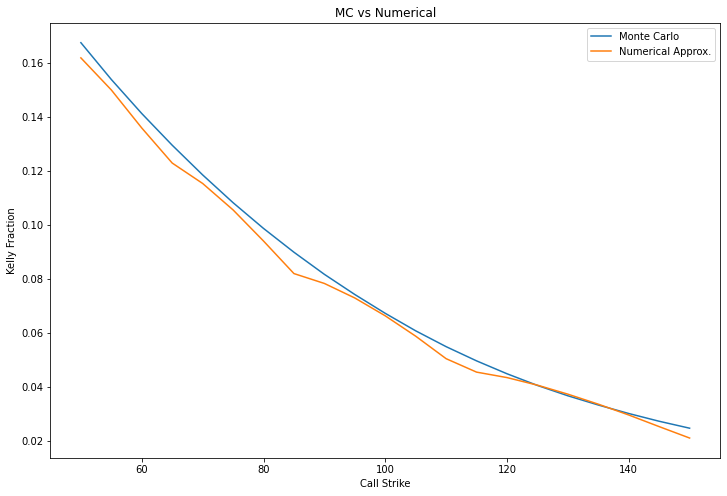

In [15]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
ax.set_xlabel('Call Strike')
ax.set_ylabel('Kelly Fraction')
ax.plot(Xrange, kellymc, label='Monte Carlo')
ax.plot(Xrange, kelly_num, label='Numerical Approx.')
ax.legend()
ax.set_title('MC vs Numerical')

In [23]:
S = 100
r = 0
T = 1
sigma_range = list(map(lambda x: x / 20, range(2,17)))
X = 150
mu = .1

In [24]:
mc_sigma_paths = {}
for sigma in sigma_range:
    mc_sigma_paths[sigma] = mc_paths(100, mu, sigma, 10000, 252) # takes about 1min w/ 10000

In [27]:
mc_sigma_results = {}
for (k,v) in mc_sigma_paths.items():
    mc_sigma_results[k] = list(map(lambda x: x[-1], v))

In [28]:
# montecarlo sim
kellymc = []
# numerical approximation
kelly_num = []
for sigma in sigma_range: 
    pr = GBlackScholes("call", S, X, T, r, sigma, 0.0)
    cr = call_return(X, mc_sigma_results[sigma], pr)
    moms = getmoms(cr)
    kmc = kelly(moms)
    kellymc.append(round(kmc,6))
    
    knum = kelly_opt(verbose=False, S=S, T=T, r=r, sigma=sigma, X=X, cost=pr, mu=mu)
    kelly_num.append(round(knum,6))
    

Text(0.5, 1.0, 'MC vs Numerical')

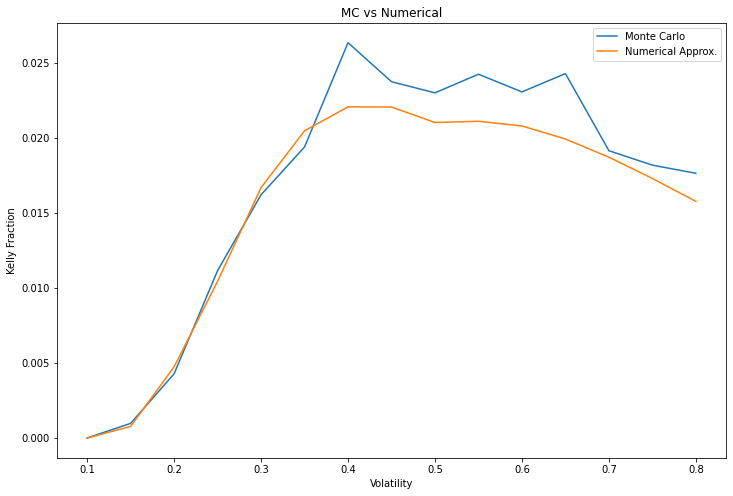

In [29]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
ax.set_xlabel('Volatility')
ax.set_ylabel('Kelly Fraction')
ax.plot(sigma_range, kellymc, label='Monte Carlo')
ax.plot(sigma_range, kelly_num, label='Numerical Approx.')
ax.legend()
ax.set_title('MC vs Numerical')

In [33]:
S = 100
r = 0
T = 1
sigma = .3
X = 150
nms = range(2,20,2)
mu = .1

mc_results = list(map(lambda x: x[-1], mc_paths(100, mu, sigma, 10000, 252)))

pr = GBlackScholes("call", S, X, T, r, sigma, 0.0)
cr = call_return(X, mc_results, pr)

kellymc = []
kk = []
for n in nms:
    moms = getmoms(cr, n)
    kmc = kelly(moms)
    kellymc.append(kmc)
    
    k = kelly_opt(verbose=False, S=S, T=T, r=r, sigma=sigma, X=X, cost=pr, mu=mu, nmoms=n)
    kk.append(k)

Text(0.5, 1.0, 'How Many Moments')

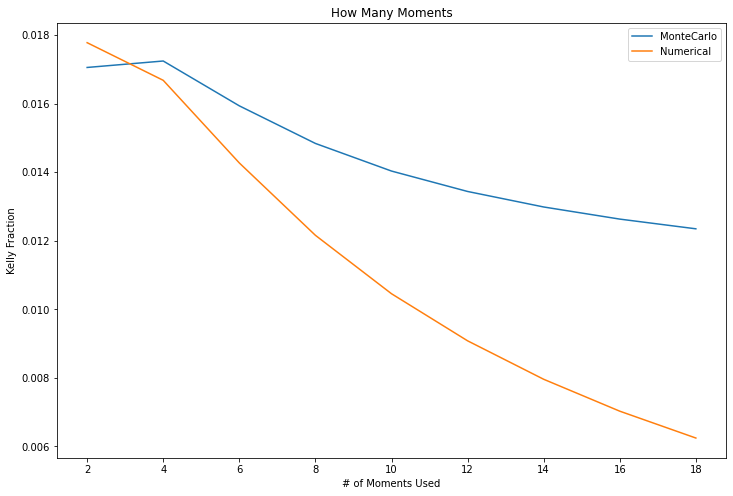

In [34]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
ax.set_xlabel('# of Moments Used')
ax.set_ylabel('Kelly Fraction')
ax.plot(list(nms), kellymc, label='MonteCarlo')
ax.plot(list(nms), kk, label='Numerical')
ax.legend()
ax.set_title('How Many Moments')